## Inference

In [7]:
from pathlib import Path
import os

def load_files(folder_route: str):
    dir_path = Path(folder_route)
    folderContent = [os.path.join(dir_path, fn) for fn in next(os.walk(dir_path))[2]]
    return folderContent


TRAIN_IMAGE_DIR = './dataset/train/images/'
TRAIN_MASK_DIR = './dataset/train/masks/'

TEST_IMAGE_DIR = './dataset/test/images/'
TEST_MASK_DIR = './dataset/test/masks/'

folder_train_image_content = load_files(TRAIN_IMAGE_DIR)
folder_train_mask_content = load_files(TRAIN_MASK_DIR)
folder_test_image_content = load_files(TEST_IMAGE_DIR)
folder_test_mask_content = load_files(TEST_MASK_DIR)

print('Path: train/images, size: ',len(folder_train_image_content))
print('Path: train/masks, size: ',len(folder_train_mask_content))
print('Path: test/images, size: ',len(folder_test_image_content))
print('Path: test/masks, size: ',len(folder_test_image_content))

Path: train/images, size:  103
Path: train/masks, size:  103
Path: test/images, size:  10
Path: test/masks, size:  10


In [8]:
from scripts.data_loader import load_and_transform

EPOCHS = 80
BATCH_SIZE =1
LEARNING_RATE = 3e-4
THRESHOLD = 0.7
USE_AMP="apex"
TRAIN_PERCENTAGE=0.7
ARCH = "Unet"
ENCODER_NAME="mobilenet_v2"
ENCODER_WEIGHTS="imagenet"
IMAGE_HEIGHT  = 1280
IMAGE_WIDTH   = 1280
display_name = "UNET-Optical-threshold-0.7-perc-0.7-epochs-80-mobilenet-1280-early-stop"

experiment=None

train_loader, val_loader, train_ds, train_val_ds, test_loader = load_and_transform(TRAIN_IMAGE_DIR,
 TRAIN_MASK_DIR,TEST_IMAGE_DIR, TEST_MASK_DIR, TRAIN_PERCENTAGE,BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH)


In [9]:
import ssl
import logging
import torch


ssl._create_default_https_context = ssl._create_unverified_context


logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [10]:
from scripts.segmentation_net import SolarPanelModel

model = SolarPanelModel(ARCH,ENCODER_NAME,ENCODER_WEIGHTS, in_channels=3, out_classes=1, learning_rate=LEARNING_RATE,
threshold=THRESHOLD, experiment=experiment )

In [11]:
model = SolarPanelModel(ARCH,ENCODER_NAME,ENCODER_WEIGHTS, in_channels=3, out_classes=1, learning_rate=LEARNING_RATE,
threshold=THRESHOLD, experiment=experiment )

model.load_state_dict(torch.load('models/'+display_name+'.pt'))
model.eval()

SolarPanelModel(
  (model): Unet(
    (encoder): MobileNetV2Encoder(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0)

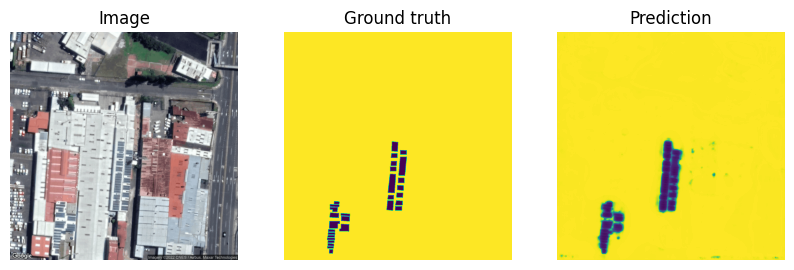

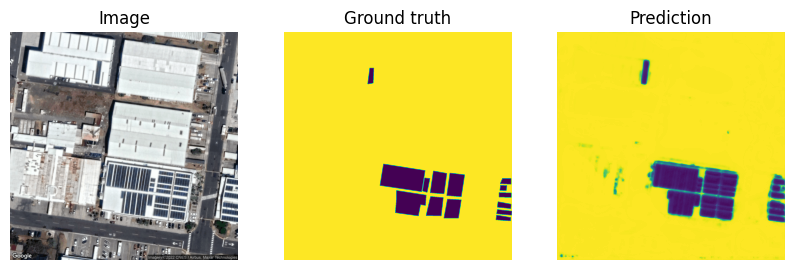

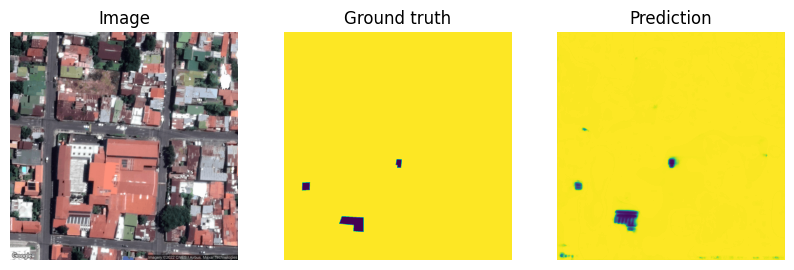

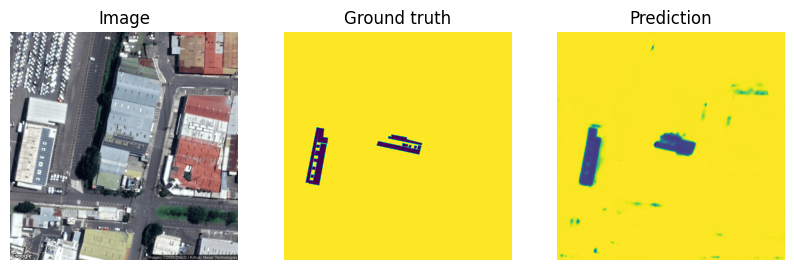

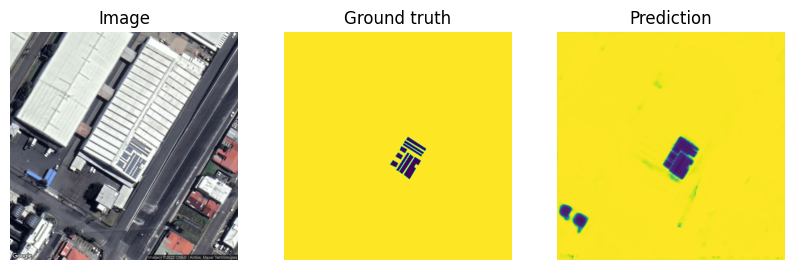

In [12]:
import torch
import matplotlib.pyplot as plt


for x in range(0, 5):
    batch= next(iter(test_loader))
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")
      
        plt.show()
